In [1]:
from GraphSampler import GraphSample
import  collections
from random import choice
import math
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time

In [131]:
import importlib
import GraphSampler
importlib.reload(GraphSampler)

<module 'GraphSampler' from '/home/kingscollege/PycharmProjects/GraphSampler/GraphSampler.py'>

In [257]:
def degree_hist(g):
    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    # returns degree, count
    return zip(*degreeCount.items())

In [261]:
g = nx.powerlaw_cluster_graph(200000,10,0.1)

In [266]:
nodes, edges = GraphSample().list_sampling(g,target_size=0.0001)
g_sample = nx.Graph()
g_sample.add_nodes_from(nodes)
g_sample.add_edges_from(edges)

In [264]:
nodes_gmd, edges_gmd, eps = GraphSample().gmd(g,target_size=0.1, C= 71)

In [265]:
nodes_rcmh, edges_rcmh = GraphSample().rcmhrw(g,target_size = 0.1, alpha= 0.1)

In [271]:
sampler = GraphSample()
c = nx.algorithms.average_clustering(g_sample)
print(c)
c1 = sampler.avg_clustering_gmd(g, nodes_gmd, eps, 0)
print(c1)
c2 = sampler.avg_clustering_rcmh(g,nodes_rcmh,0.1)
print(c2)

0.024340286350332422
0.019260648934547
0.017362474086165435


In [268]:
rcmh_subgraph = g.subgraph(nodes_rcmh)

In [2]:
web = nx.read_edgelist("data/web-BerkStan.txt")

In [3]:
print(len(web.nodes))
# should be 685230
print(len(web.edges))
# should be 7600595

685230
6649470


In [34]:
experiment_result = pd.DataFrame(columns=["percentage","n","avg_clustering","degrees","run",
                                          "time_sample","time_clust"])
print(experiment_result)

Empty DataFrame
Columns: [percentage, n, avg_clustering, degrees, run, time_sample, time_clust]
Index: []


In [103]:
experiment_result = pd.DataFrame(columns=["percentage","n","avg_clustering","degrees","run",
                                          "time_sample","time_clust"])
sampler = GraphSample()
for n in range(1,6,1):
    print("n %s" % n)
    for run in range(0,1):
        print("run %s" % run)
        
        time_sample_start = time.time()
        nodes_gmd, edges_gmd, eps = GraphSample().gmd(web,target_size=n/1000, C= 71)
        time_sample = time.time() - time_sample_start
        time_sample = float('%.2f' % time_sample)
        
        nodes = len(nodes_gmd)
        
        time_clust_start = time.time()
        clustering = sampler.avg_clustering_gmd(web,nodes_gmd,eps,71)
        time_clust = time.time() - time_clust_start
        time_clust = float('%.2f' % time_clust)
        
        degrees = web.degree(nbunch=nodes_gmd)
        experiment_result = experiment_result.append({"percentage":n,"n":nodes,"avg_clustering":clustering,
                                  "degrees":degrees,"run":run,"C":71,
                                  "time_sample":time_sample,"time_clust":time_clust}, ignore_index=True)

n 1
run 0
n 2
run 0
n 3
run 0
n 4
run 0
n 5
run 0


In [101]:
print(experiment_result.head())

  percentage     n avg_clustering  \
0          1   686              0   
1          2  1371              0   
2          3  2056              0   
3          4  2741              0   
4          1   686              0   

                                             degrees run  time_sample  \
0  ((477252, 5), (481959, 8510), (483323, 5), (48...   0         0.88   
1  ((52180, 39), (56289, 11), (52170, 1420), (559...   0         1.97   
2  ((514130, 12), (639947, 1058), (640032, 12), (...   0         1.32   
3  ((224084, 9), (224439, 8), (223967, 8), (22420...   0         2.97   
4  ((159963, 14), (159987, 45), (160024, 9), (160...   0         1.67   

  time_clust     C  
0          0  71.0  
1          0  71.0  
2          0  71.0  
3          0  71.0  
4          0  71.0  


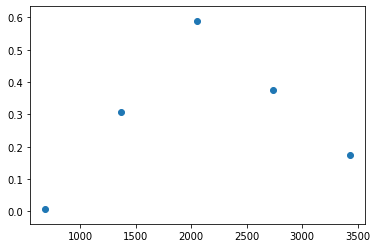

In [109]:
%matplotlib inline
plt.scatter(experiment_result["n"],abs(0.59-experiment_result["avg_clustering"]))

In [ ]:
g = nx.powerlaw_cluster_graph(200,10,0.1)
nodes, edges = GraphSample().list_sampling(g,target_size=0.0001)
g_sample = nx.Graph()
g_sample.add_nodes_from(nodes)
g_sample.add_edges_from(edges)

In [139]:
sampler = GraphSample()
experiment_result = pd.DataFrame(columns=["percentage","avg_clustering","degrees",
                                          "true_clust","alg","C","alpha","m","true_degree"])
for m in [1,26,75,250,500]:
    print(m)
    g = nx.barabasi_albert_graph(5000,m, seed = 0)
    true_clust = nx.average_clustering(g)
    for run in range(5):

        
        nodes, edges = GraphSample().list_sampling(g,target_size=0.1)
        g_sample = nx.Graph()
        g_sample.add_nodes_from(nodes)
        g_sample.add_edges_from(edges)
        list_clust = nx.average_clustering(g_sample)
        experiment_result = experiment_result.append({"percentage":0.1,"avg_clustering":list_clust,
                                  "degrees":nx.degree(g_sample),"true_clust":true_clust,
                                  "alg":"list","m":m,"true_degree":nx.degree(g)},ignore_index=True)
        nodes_gmd, edges_gmd, eps = GraphSample().gmd(g,target_size=0.1, C= 50)
        gmd_clust = sampler.avg_clustering_gmd(g,nodes_gmd,eps,50)
        experiment_result = experiment_result.append({"percentage":0.1,"avg_clustering":gmd_clust,
                                  "degrees":nx.degree(g,nodes_gmd),"true_clust":true_clust,
                                  "alg":"gmd", "C": 50,"m":m,"true_degree":nx.degree(g)},ignore_index=True)    
        nodes_rcmh, edges_rcmh = GraphSample().rcmhrw(g,target_size = 0.1, alpha= 0.1)
        rcmh_clust = sampler.avg_clustering_rcmh(g,nodes_rcmh,0.1)
        experiment_result = experiment_result.append({"percentage":0.1,"avg_clustering":rcmh_clust,
                                  "degrees":nx.degree(g,nodes_rcmh),"true_clust":true_clust,
                                  "alg":"rcmh", "alpha": 0.1,"m":m,"true_degree":nx.degree(g)},ignore_index=True)    
        
print("done")

1
26
75
250
500
done


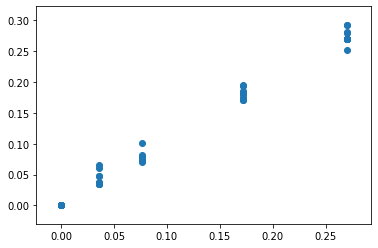

In [140]:
plt.scatter(experiment_result["true_clust"],experiment_result["avg_clustering"])

In [ ]:
experiment_result.to_csv("results/barabasi.csv")

In [2]:
results = pd.read_csv("results/barabasi.csv")

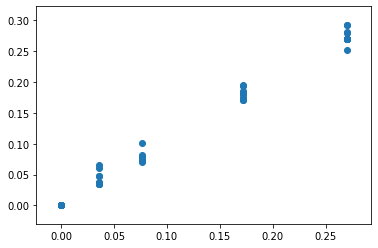

In [3]:
plt.scatter(results["true_clust"],results["avg_clustering"])

(array([359.,  65.,  34.,   0.,  30.,   0.,   0.,   0.,   0.,  12.]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <a list of 10 Patch objects>)

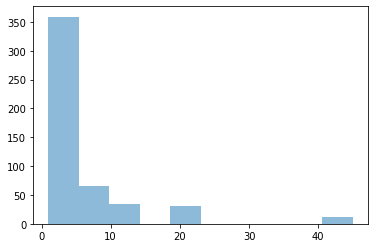

In [25]:
import seaborn as sns

#plt.hist(y, bins, alpha=0.5, label='y')
#pyplot.legend(loc='upper right')
#pyplot.show()

In [9]:
deg = [x for x in results.loc[5]["degrees"][1]]
print(deg)

['(']


In [30]:
temp = results.loc[5]["degrees"].replace("(","")
temp = temp.replace(")","")
temp = temp.replace("[","")
temp = temp.replace("]","")
temp = temp.replace(" ","")
temp = temp.split(",")
temp = list(map(int,temp))
final  = list()
deg  = list()
for x in range(0,len(temp),2):
    final.append((temp[x],temp[x+1]))
    deg.append(temp[x+1])
print(final)
print(deg)

[(3456, 1), (2121, 3), (3456, 1), (2121, 3), (1159, 3), (266, 10), (2818, 1), (266, 10), (3204, 2), (4376, 1), (3204, 2), (266, 10), (3974, 1), (266, 10), (1771, 4), (4853, 1), (1771, 4), (266, 10), (123, 10), (4532, 1), (123, 10), (43, 19), (1686, 1), (43, 19), (651, 1), (43, 19), (4119, 1), (43, 19), (651, 1), (43, 19), (4369, 1), (43, 19), (4119, 1), (43, 19), (4798, 1), (43, 19), (4798, 1), (43, 19), (1686, 1), (43, 19), (3126, 1), (43, 19), (76, 9), (1431, 1), (76, 9), (4398, 1), (76, 9), (4398, 1), (76, 9), (511, 1), (76, 9), (1431, 1), (76, 9), (2234, 1), (76, 9), (511, 1), (76, 9), (4579, 1), (76, 9), (2234, 1), (76, 9), (2548, 3), (3560, 1), (2548, 3), (3606, 1), (2548, 3), (76, 9), (511, 1), (76, 9), (2234, 1), (76, 9), (1431, 1), (76, 9), (43, 19), (4170, 1), (43, 19), (2351, 2), (4560, 1), (2351, 2), (4560, 1), (2351, 2), (4560, 1), (2351, 2), (4560, 1), (2351, 2), (43, 19), (2137, 1), (43, 19), (4369, 1), (43, 19), (4170, 1), (43, 19), (432, 10), (2765, 1), (432, 10), (948

(array([359.,  65.,  34.,   0.,  30.,   0.,   0.,   0.,   0.,  12.]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <a list of 10 Patch objects>)

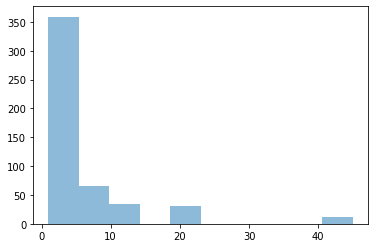

In [31]:
plt.hist(deg, alpha=0.5, label='x')

In [40]:
def convert_degree(entry):
    temp = entry.replace("(","")
    temp = temp.replace(")","")
    temp = temp.replace("[","")
    temp = temp.replace("]","")
    temp = temp.replace(" ","")
    temp = temp.split(",")
    temp = list(map(int,temp))
    final_true  = list()
    for x in range(0,len(temp),2):
        final_true.append((temp[x],temp[x+1]))
    return(final_true)

(array([4.758e+03, 1.680e+02, 3.200e+01, 1.500e+01, 1.200e+01, 1.000e+00,
        5.000e+00, 1.000e+00, 2.000e+00, 3.000e+00]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <a list of 10 Patch objects>)

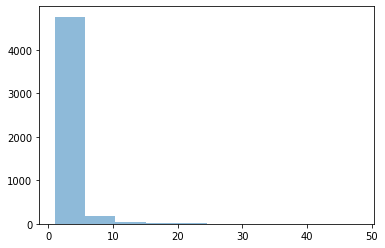

In [43]:
true_degree = convert_degree(results.loc[5]["true_degree"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg if x<50], alpha=0.5, label='x')

In [44]:
results.head()

,Unnamed: 0,percentage,avg_clustering,degrees,true_clust,alg,C,alpha,m,true_degree
0,0,0.1,0.0,"[(4000, 1), (271, 14), (1512, 1), (1749, 1), (...",0.0,list,NaN,NaN,1,"[(0, 159), (1, 12), (2, 52), (3, 2), (4, 30), ..."
1,1,0.1,0.0,"[(657, 4), (354, 2), (171, 4), (1123, 2), (171...",0.0,gmd,50.0,NaN,1,"[(0, 159), (1, 12), (2, 52), (3, 2), (4, 30), ..."
2,2,0.1,0.0,"[(2889, 2), (4135, 1), (2889, 2), (4135, 1), (...",0.0,rcmh,NaN,0.1,1,"[(0, 159), (1, 12), (2, 52), (3, 2), (4, 30), ..."
3,3,0.1,0.0,"[(4758, 1), (3722, 2), (1802, 2), (470, 9), (3...",0.0,list,NaN,NaN,1,"[(0, 159), (1, 12), (2, 52), (3, 2), (4, 30), ..."
4,4,0.1,0.0,"[(3636, 1), (537, 6), (93, 6), (2798, 1), (93,...",0.0,gmd,50.0,NaN,1,"[(0, 159), (1, 12), (2, 52), (3, 2), (4, 30), ..."


In [49]:
list_results = results[results["alg"]=="list"]
rcmh_results = results[results["alg"]=="rcmh"]
gmd_results = results[results["alg"]=="gmd"]

    Unnamed: 0  percentage  avg_clustering  \
0            0         0.1        0.000000   
3            3         0.1        0.000000   
6            6         0.1        0.000000   
9            9         0.1        0.000000   
12          12         0.1        0.000000   
15          15         0.1        0.060233   
18          18         0.1        0.036057   
21          21         0.1        0.047012   
24          24         0.1        0.048018   
27          27         0.1        0.064954   

                                              degrees  true_clust   alg   C  \
0   [(4000, 1), (271, 14), (1512, 1), (1749, 1), (...     0.00000  list NaN   
3   [(4758, 1), (3722, 2), (1802, 2), (470, 9), (3...     0.00000  list NaN   
6   [(3931, 1), (750, 3), (0, 121), (4099, 1), (18...     0.00000  list NaN   
9   [(949, 4), (2116, 2), (664, 6), (4232, 1), (61...     0.00000  list NaN   
12  [(6, 35), (209, 3), (4291, 1), (106, 17), (358...     0.00000  list NaN   
15  [(2357, 10), (1

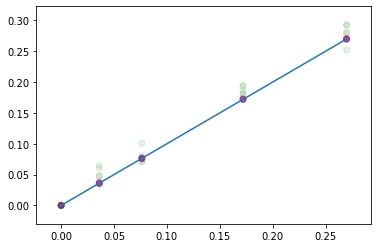

In [58]:
# They are all fairly exact but list algorithm seems to have higher variablity 
colors = {'rcmh':'red', 'gmd':'blue', 'list':'green'}
plt.scatter(results["true_clust"], results["avg_clustering"], c = results["alg"].apply(lambda x: colors[x]), alpha=0.1)
plt.plot(results["true_clust"],results["true_clust"])

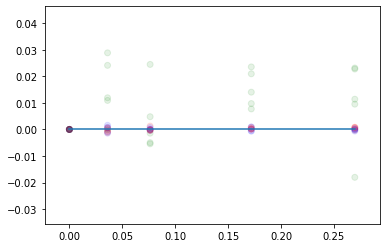

In [62]:
# variability much better seen for green
plt.scatter(results["true_clust"], results["avg_clustering"]-results["true_clust"], c = results["alg"].apply(lambda x: colors[x]), alpha=0.1)
plt.plot(results["true_clust"],results["true_clust"]-results["true_clust"])

In [ ]:
# next steps: change alpha and sample size and measure avg clustering and degree distribution
# next steps: change C and sample size and measure avg clustering and degree distribution
# next steps: measure the time the different algorithms take to complete with change in degree distribution and alpha 
# (could be that it gets rejected a lot and takes a long time to finish)
# next steps: quantify variability of list algorithm
